In [1]:
import numpy as np
import os
# import six.moves.urllib as urllib
import sys
# import tarfile
import tensorflow as tf
# import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

# This is needed to display the images.
%matplotlib inline

## Object detection imports
# Here are the imports from the object detection module.
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

In [2]:
PATH_TO_FROZEN_GRAPH = 'models/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [3]:
PATH_TO_LABELS = "E:\\UAV_drone\\data\\object_detection\\training\\label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.JPG'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [6]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

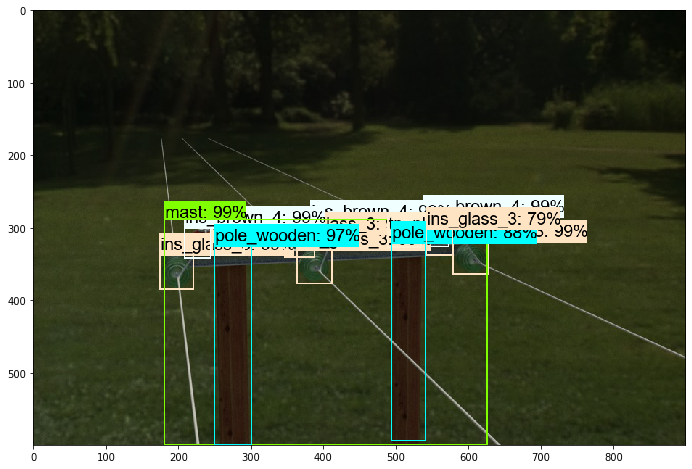

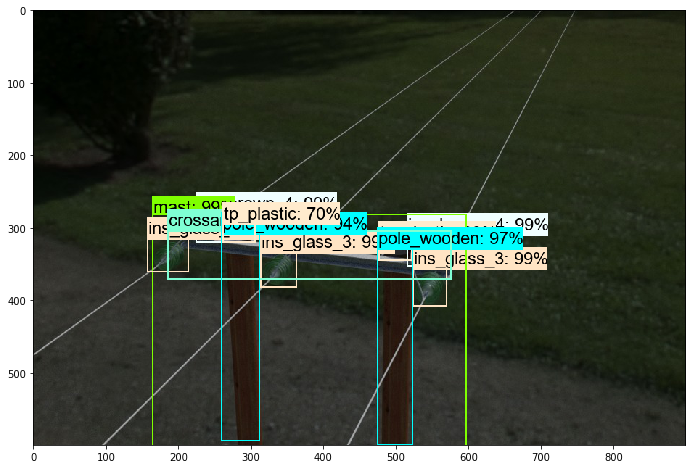

In [7]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)

    plt.imshow(image_np)

(262144, 4)
4, 0.9935985803604126, [0.42766368 0.34537327 0.4912529  0.40758723]

4, 0.9623430967330933, [0.41478267 0.21042256 0.47033265 0.2852951 ]

3, 0.6972514390945435, [0.         0.0158211  0.34436548 0.97863215]

4, 0.6486455798149109, [0.40777433 0.09437514 0.46102428 0.18348736]

(262144, 4)
4, 0.939224123954773, [0.4561763  0.3061045  0.5148127  0.36392412]

4, 0.561137318611145, [0.412819   0.23899327 0.46885464 0.2982421 ]

(262144, 4)
(262144, 4)
(262144, 4)
4, 0.9737074971199036, [0.4338335  0.20094883 0.5058253  0.2914064 ]

(262144, 4)
4, 0.9539048671722412, [0.3626724  0.05568115 0.41863436 0.13886032]

4, 0.5200656652450562, [0.37059814 0.15270853 0.42339045 0.24331725]

(262144, 4)
4, 0.9315279722213745, [0.4416292  0.3645813  0.5001397  0.42987555]

4, 0.895042896270752, [0.41237155 0.27050588 0.46618095 0.34816864]

3, 0.6528482437133789, [0.         0.00569901 0.28972238 0.944958  ]

(262144, 4)
4, 0.9633611440658569, [0.53300184 0.23381461 0.60519975 0.33273983

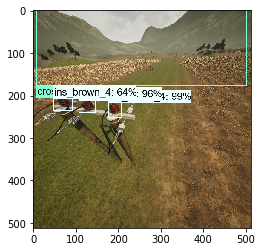

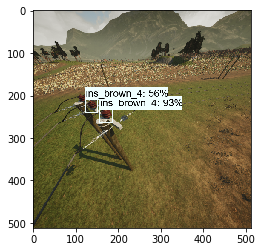

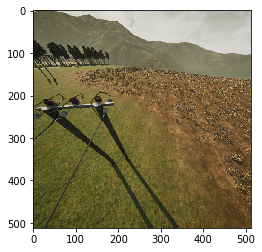

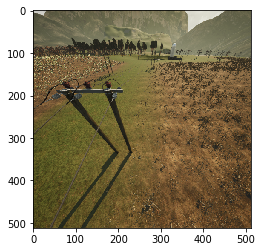

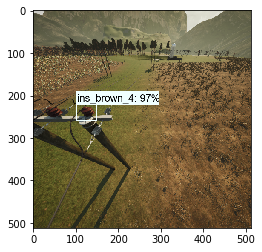

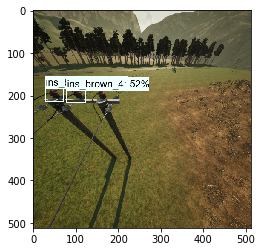

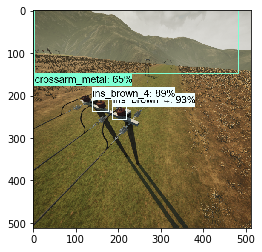

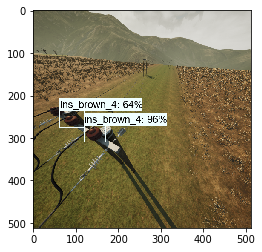

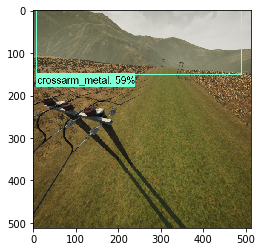

In [8]:
def load_image_into_numpy_array_1(image):
  (im_width, im_height) = image.size
  return (np.array(image.getdata())[:, :3]).reshape(
      (512, 512, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(3, 12) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (4, 4)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    print (np.array(image.getdata()).shape)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array_1(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
    n = len(output_dict['detection_scores'])
    for i in range (0,n):
        if output_dict['detection_scores'][i] > 0.5: 
            print ("{}, {}, {}\n".format(output_dict['detection_classes'][i], 
                                         output_dict['detection_scores'][i], 
                                         output_dict['detection_boxes'][i]))

    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

(262144, 4)
4, 0.9656516313552856, [0.4266524 0.5119543 0.4839203 0.5623832]

3, 0.6448479890823364, [0.         0.00723997 0.36727053 1.        ]

(262144, 4)
4, 0.9954322576522827, [0.41894245 0.53900105 0.47465038 0.5908305 ]

4, 0.7176907062530518, [0.36221278 0.47230536 0.41670263 0.52994984]

3, 0.6716721057891846, [0.         0.         0.37184852 0.99038196]

(262144, 4)
4, 0.9292653203010559, [0.47510877 0.37408492 0.5328326  0.43866065]

3, 0.6161766648292542, [0.         0.02055907 0.33583322 0.9915894 ]

4, 0.5767405033111572, [0.5912091  0.42380294 0.6678851  0.49398234]

(262144, 4)
4, 0.9935085773468018, [0.42080063 0.3705538  0.47544247 0.4313432 ]

3, 0.9793074727058411, [0.4388879  0.35653093 0.8270994  0.65193164]

4, 0.9663147330284119, [0.6175399  0.49471164 0.70671475 0.57007277]

4, 0.9062957167625427, [0.4912458  0.41678134 0.55128044 0.47823212]

3, 0.6543579697608948, [0.         0.02179798 0.33594245 0.978487  ]

(262144, 4)
4, 0.9915314316749573, [0.51482993

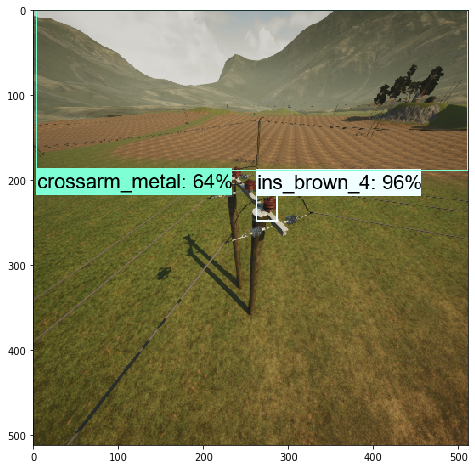

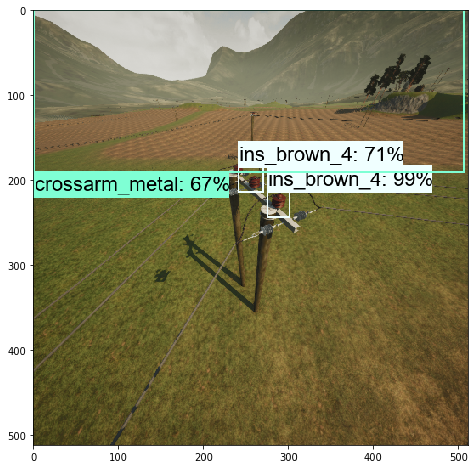

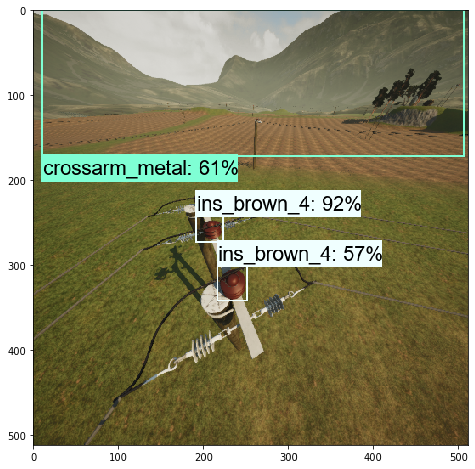

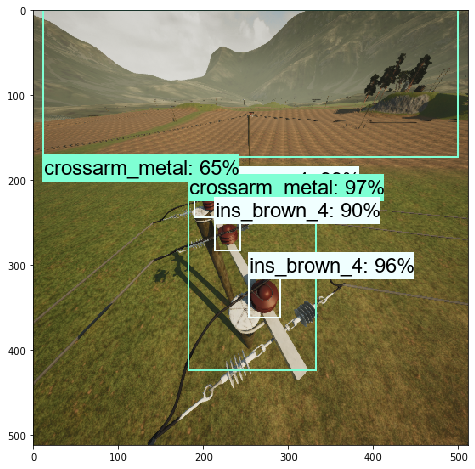

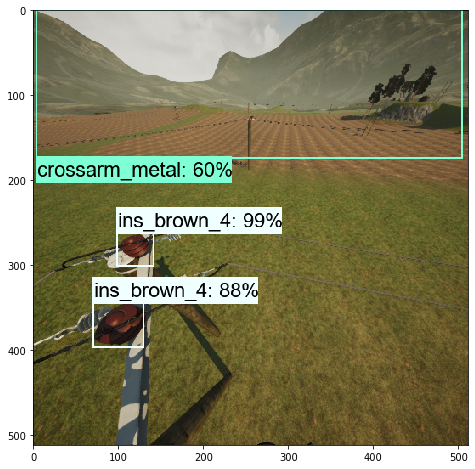

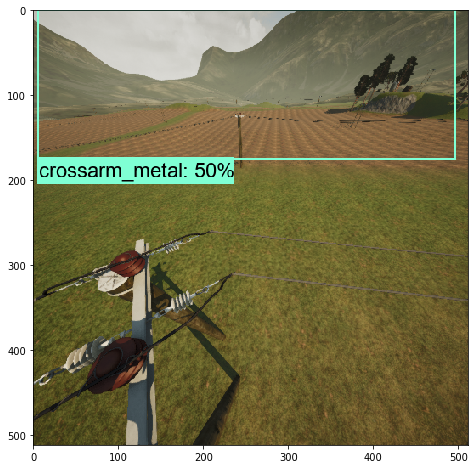

In [12]:
def load_image_into_numpy_array_1(image):
  (im_width, im_height) = image.size
  return (np.array(image.getdata())[:, :3]).reshape(
      (512, 512, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'mast{}.png'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (8, 8)
ii = 1
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    print (np.array(image.getdata()).shape)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array_1(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
    n = len(output_dict['detection_scores'])
    for i in range (0,n):
        if output_dict['detection_scores'][i] > 0.5: 
            print ("{}, {}, {}\n".format(output_dict['detection_classes'][i], 
                                         output_dict['detection_scores'][i], 
                                         output_dict['detection_boxes'][i]))

    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    
    # save image
    plt.savefig("test_images/mast"+str(ii)+"predict.png")
    ii+=1